In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from functools import reduce
import matplotlib.patches as mpatches
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols as reg
from scipy.stats import trim_mean

Data locations

In [19]:
disease="Scarlet fever" 
phase = "ENSO"
enso_var ="e_e-and-c"# "e_e-and-c"
response ="log_rate"#"incidence" # "log_rate" 
exclude_iso =[]
nlag =6
filter="100"
running_month="4"
diease_label = "Scarlet fever"

In [ ]:
loc_enso = "../../Data/ENSO_Indices/CMIP6/"
loc_damages = "../../Data/Future/Future_risk/"
loc_tc = "../../Data/Teleconnections/CMIP6/"
loc_pop="../../Data/Future/Pop/"
time_damages = pd.date_range(start="2030-01-01" ,end="2092-12-31",freq="YS")

In [4]:
from scipy.stats import trim_mean
def trimmed_mean_ignore_nan(array, proportion_to_cut):
    array = array[~np.isnan(array)]
    if array.size == 0:
        return np.nan
    return trim_mean(array, proportiontocut=proportion_to_cut)

def compute_trimmed_mean(data_array, dim, proportion_to_cut):
    return xr.apply_ufunc(
        trimmed_mean_ignore_nan,
        data_array,
        input_core_dims=[[dim]],  
        kwargs={'proportion_to_cut': proportion_to_cut}, 
        vectorize=True
    )

Years

In [5]:
y1 = 2030
y2 = 2092

#### Analysis

read damages

In [6]:
exps = ["ssp126","ssp245","ssp370","ssp585"]
import warnings
warnings.filterwarnings("ignore",category=FutureWarning,message="'base' in .resample")
for e in exps:
    print(e)
    
    # load ENSO and teleconnection data
    enso_models = np.array([m.split("_")[0]+"_"+m.split("_")[1] for m in sorted(os.listdir(loc_enso)) if e in m])
    enso_files = np.array([loc_enso+m for m in sorted(os.listdir(loc_enso)) if e in m])
    enso_ds = xr.open_mfdataset(enso_files,concat_dim="model",combine="nested")
    enso_ds.coords["model"] = enso_models
    alphas = enso_ds.alpha.load()
    alpha_threshold = -0.17 # half the obs value of -0.34
    e_index = enso_ds.e_index.load()
    c_index = enso_ds.c_index.load()
    e_shift = e_index.shift(time=1)
    e_djf = e_index.rolling(time=int(running_month)).mean()
    e_djf.coords["time"] = e_djf.time.dt.year.values
    c_shift = c_index.shift(time=1)
    c_djf = c_index.rolling(time=int(running_month)).mean()
    c_djf.coords["time"] = c_djf.time.dt.year.values
    
    models = np.array([m.split("_")[0]+"_"+m.split("_")[1] for m in sorted(os.listdir(loc_tc)) if (e in m)&("teleconnections_1960" in m)])
    models_files = np.array([loc_tc+m for m in sorted(os.listdir(loc_tc)) if (e in m)&("teleconnections_1960" in m)])
    tc_ds = xr.open_mfdataset(models_files,concat_dim="model",combine="nested")
    tc_ds.coords["model"] = models
    tc_corr_e = tc_ds.teleconnections_corr_running.sel(index="e").load()
    tc_corr_c = tc_ds.teleconnections_corr_running.sel(index="c").load()
    
    if e=="ssp126":
        damages_e_126 = xr.open_dataset(loc_damages+disease+"/CMIP6_damages_amplitude_teleconnections_"+e+"_main_"+str(y1)+"-"+str(y2)+".nc")
        e_126 = e_djf.loc[damages_e_126.model.values,:]  
        c_126 = c_djf.loc[damages_e_126.model.values,:]  
        tc_change_126_e = tc_corr_e.loc[damages_e_126.model.values,"future",:] - tc_corr_e.loc[damages_e_126.model.values,"hist",:]
        tc_change_126_pct_e = 100*tc_change_126_e/tc_corr_e.loc[damages_e_126.model.values,"hist",:]  
        tc_change_126_c = tc_corr_c.loc[damages_e_126.model.values,"future",:] - tc_corr_c.loc[damages_e_126.model.values,"hist",:] 
        tc_change_126_pct_c = 100*tc_change_126_c/tc_corr_c.loc[damages_e_126.model.values,"hist",:]  
        provinces=damages_e_126.iso.values
    elif e=="ssp245":
        damages_e_245 = xr.open_dataset(loc_damages+disease+"/CMIP6_damages_amplitude_teleconnections_"+e+"_main_"+str(y1)+"-"+str(y2)+".nc")
        e_245 = e_djf.loc[damages_e_245.model.values,:]
        c_245 = c_djf.loc[damages_e_245.model.values,:]
        tc_change_245_e = tc_corr_e.loc[damages_e_245.model.values,"future",:] - tc_corr_e.loc[damages_e_245.model.values,"hist",:]
        tc_change_245_pct_e = 100*tc_change_245_e/tc_corr_e.loc[damages_e_245.model.values,"hist",:]
        tc_change_245_c = tc_corr_c.loc[damages_e_245.model.values,"future",:] - tc_corr_c.loc[damages_e_245.model.values,"hist",:]
        tc_change_245_pct_c = 100*tc_change_245_c/tc_corr_c.loc[damages_e_245.model.values,"hist",:]
    elif e=="ssp370":
        damages_e_370 = xr.open_dataset(loc_damages+disease+"/CMIP6_damages_amplitude_teleconnections_"+e+"_main_"+str(y1)+"-"+str(y2)+".nc")
        e_370 = e_djf.loc[damages_e_370.model.values,:]
        c_370 = c_djf.loc[damages_e_370.model.values,:]
        tc_change_370_e = tc_corr_e.loc[damages_e_370.model.values,"future",:] - tc_corr_e.loc[damages_e_370.model.values,"hist",:]
        tc_change_370_pct_e = 100*tc_change_370_e/tc_corr_e.loc[damages_e_370.model.values,"hist",:]
        tc_change_370_c = tc_corr_c.loc[damages_e_370.model.values,"future",:] - tc_corr_c.loc[damages_e_370.model.values,"hist",:]
        tc_change_370_pct_c = 100*tc_change_370_c/tc_corr_c.loc[damages_e_370.model.values,"hist",:]
    elif e=="ssp585":
        damages_e_585 = xr.open_dataset(loc_damages+disease+"/CMIP6_damages_amplitude_teleconnections_"+e+"_main_"+str(y1)+"-"+str(y2)+".nc")
        e_585 = e_djf.loc[damages_e_585.model.values,:]
        c_585 = c_djf.loc[damages_e_585.model.values,:]
        tc_change_585_e = tc_corr_e.loc[damages_e_585.model.values,"future",:] - tc_corr_e.loc[damages_e_585.model.values,"hist",:]
        tc_change_585_pct_e = 100*tc_change_585_e/tc_corr_e.loc[damages_e_585.model.values,"hist",:]
        tc_change_585_c = tc_corr_c.loc[damages_e_585.model.values,"future",:] - tc_corr_c.loc[damages_e_585.model.values,"hist",:]
        tc_change_585_pct_c = 100*tc_change_585_c/tc_corr_c.loc[damages_e_585.model.values,"hist",:]

ssp126
ssp245
ssp370
ssp585


In [7]:

amp_change_126_e = e_126.loc[:,2030:2092].std(dim="time") - e_126.loc[:,1960:2022].std(dim="time")  
amp_change_245_e = e_245.loc[:,2030:2092].std(dim="time") - e_245.loc[:,1960:2022].std(dim="time")
amp_change_370_e = e_370.loc[:,2030:2092].std(dim="time") - e_370.loc[:,1960:2022].std(dim="time")
amp_change_585_e = e_585.loc[:,2030:2092].std(dim="time") - e_585.loc[:,1960:2022].std(dim="time")
amp_change_126_pct_e = 100*amp_change_126_e/e_126.loc[:,1960:2022].std(dim="time") 
amp_change_245_pct_e = 100*amp_change_245_e/e_245.loc[:,1960:2022].std(dim="time")
amp_change_370_pct_e = 100*amp_change_370_e/e_370.loc[:,1960:2022].std(dim="time")
amp_change_585_pct_e = 100*amp_change_585_e/e_585.loc[:,1960:2022].std(dim="time")


amp_change_126_c = c_126.loc[:,2030:2092].std(dim="time") - c_126.loc[:,1960:2022].std(dim="time") 
amp_change_245_c = c_245.loc[:,2030:2092].std(dim="time") - c_245.loc[:,1960:2022].std(dim="time")
amp_change_370_c = c_370.loc[:,2030:2092].std(dim="time") - c_370.loc[:,1960:2022].std(dim="time")
amp_change_585_c = c_585.loc[:,2030:2092].std(dim="time") - c_585.loc[:,1960:2022].std(dim="time")
amp_change_126_pct_c = 100*amp_change_126_c/c_126.loc[:,1960:2022].std(dim="time") 
amp_change_245_pct_c = 100*amp_change_245_c/c_245.loc[:,1960:2022].std(dim="time")
amp_change_370_pct_c = 100*amp_change_370_c/c_370.loc[:,1960:2022].std(dim="time")
amp_change_585_pct_c = 100*amp_change_585_c/c_585.loc[:,1960:2022].std(dim="time")

print(amp_change_126_e)
print(amp_change_245_e)

<xarray.DataArray 'e_index' (model: 34)> Size: 272B
array([ 0.18678118,  0.07864921,  0.17488948,  0.0998991 ,  0.17017055,
        0.19898418,  0.28862982,  0.13396933,  0.09535329,  0.1201344 ,
       -0.09279683,  0.01635279,  0.17085085, -0.20292164,  0.13058241,
       -0.22451649,  0.00288593,  0.0240524 ,  0.09319845, -0.20137906,
        0.03659466, -0.01159889, -0.10549663,  0.09177308,  0.09564476,
       -0.22843896, -0.05437758, -0.11039935,  0.0423695 ,  0.24786333,
        0.20951971,  0.20245748, -0.03482374, -0.13403614])
Coordinates:
  * model    (model) <U22 3kB 'MIROC-ES2L_r10i1p1f2' ... 'MIROC6_r9i1p1f1'
<xarray.DataArray 'e_index' (model: 61)> Size: 488B
array([ 0.21997971,  0.18650515,  0.18513618, -0.04668926,  0.1518465 ,
        0.07176191,  0.23360984,  0.17965009,  0.19433951,  0.07212905,
        0.2004501 ,  0.26250073,  0.33067631,  0.17320879,  0.29007835,
        0.10276539,  0.28355758,  0.24646151,  0.32377087,  0.26903651,
        0.22369325,  0.12050

In [8]:
y1_e_sum = 2030
y2_e_sum = 2092
e_126_future = e_126.loc[:,y1:y2] #- e_126.loc[:,y1:y2].mean()
e_245_future = e_245.loc[:,y1:y2] #- e_245.loc[:,y1:y2].mean()
e_370_future = e_370.loc[:,y1:y2] #- e_370.loc[:,y1:y2].mean()
e_585_future = e_585.loc[:,y1:y2] #- e_585.loc[:,y1:y2].mean()

###e
e_sum_126 = e_126_future.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")   
e_sum_245 = e_245_future.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")
e_sum_370 = e_370_future.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")
e_sum_585 = e_585_future.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")

###c
c_sum_126 = c_126.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")   
c_sum_245 = c_245.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")
c_sum_370 = c_370.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")
c_sum_585 = c_585.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")

In [9]:
#### Calculate the number of people with the disease
def compute_pop(e):
    pop= xr.open_dataset(loc_pop+"pop_"+e[0:4]+"_2020-2100.nc")
    pop['Year']=pd.to_datetime(pop['Year'].values, format='%Y')
    pop = pop.rename({'Year':'time'})
    pop=np.exp(pop["Population"])*10000000
    pop_new = pop.interp(time=time_damages,method='nearest')
    pop_new=pop_new.sel(iso=provinces)
    return pop_new

In [10]:
pop_126=compute_pop("ssp126")
pop_245=compute_pop("ssp245")
pop_370=compute_pop("ssp370")
pop_585=compute_pop("ssp585")

damages_e_plot_126 = ((damages_e_126.damage_year*pop_126/100000).sum(dim="iso").sum(dim="time"))/1e4  #维度为["boot","iso","model"]
damages_e_plot_245 = ((damages_e_245.damage_year*pop_245/100000).sum(dim="iso").sum(dim="time"))/1e4
damages_e_plot_370 = (damages_e_370.damage_year*pop_370/100000).sum(dim="iso").sum(dim="time")/1e4
damages_e_plot_585 = (damages_e_585.damage_year*pop_585/100000).sum(dim="iso").sum(dim="time")/1e4

In [11]:

damages_126_median = damages_e_plot_126.median(dim=["boot"])  
damages_245_median = damages_e_plot_245.median(dim=["boot"])
damages_370_median = damages_e_plot_370.median(dim=["boot"])
damages_585_median = damages_e_plot_585.median(dim=["boot"])
damages_126_mean=compute_trimmed_mean(damages_e_plot_126,"boot",proportion_to_cut=0.1)
damages_245_mean=compute_trimmed_mean(damages_e_plot_245,"boot",proportion_to_cut=0.1)
damages_370_mean=compute_trimmed_mean(damages_e_plot_370,"boot",proportion_to_cut=0.1)
damages_585_mean=compute_trimmed_mean(damages_e_plot_585,"boot",proportion_to_cut=0.1)


In [12]:
e_sum_pooled = np.concatenate([e_sum_126.values,e_sum_245.values,e_sum_370.values,e_sum_585.values]) #concatenate连接数组
c_sum_pooled = np.concatenate([c_sum_126.values,c_sum_245.values,c_sum_370.values,c_sum_585.values])
amp_change_e_pooled = np.concatenate([amp_change_126_e.values,amp_change_245_e.values,amp_change_370_e.values,amp_change_585_e.values])
amp_change_e_pct_pooled = np.concatenate([amp_change_126_pct_e.values,amp_change_245_pct_e.values,amp_change_370_pct_e.values,amp_change_585_pct_e.values])
amp_change_c_pooled = np.concatenate([amp_change_126_c.values,amp_change_245_c.values,amp_change_370_c.values,amp_change_585_c.values])
amp_change_c_pct_pooled = np.concatenate([amp_change_126_pct_c.values,amp_change_245_pct_c.values,amp_change_370_pct_c.values,amp_change_585_pct_c.values])
damages_pooled = np.concatenate([damages_126_median.values,damages_245_median.values,damages_370_median.values,damages_585_median.values])
damages_pooled2 = np.concatenate([damages_126_mean.values,damages_245_mean.values,damages_370_mean.values,damages_585_mean.values])
tc_change_e_pooled = np.concatenate([tc_change_126_e.mean(dim="iso").values,tc_change_245_e.mean(dim="iso").values,tc_change_370_e.mean(dim="iso").values,tc_change_585_e.mean(dim="iso").values])
tc_change_e_pct_pooled = np.concatenate([tc_change_126_pct_e.mean(dim="iso").values,tc_change_245_pct_e.mean(dim="iso").values,tc_change_370_pct_e.mean(dim="iso").values,tc_change_585_pct_e.mean(dim="iso").values])
tc_change_c_pooled= np.concatenate([tc_change_126_c.mean(dim="iso").values,tc_change_245_c.mean(dim="iso").values,tc_change_370_c.mean(dim="iso").values,tc_change_585_c.mean(dim="iso").values])
tc_change_c_pct_pooled= np.concatenate([tc_change_126_pct_c.mean(dim="iso").values,tc_change_245_pct_c.mean(dim="iso").values,tc_change_370_pct_c.mean(dim="iso").values,tc_change_585_pct_c.mean(dim="iso").values])

Plot a new version of Fig 4

ssp126
Median 8.639054134263947
Confidence interval -2.6244463917452316 22.59366485426179
Skewness 0.9368290523444273
ssp245
Median 9.606723698920801
Confidence interval 0.9914532512140513 36.07529444960487
Skewness 5.341588690730778
ssp370
Median 14.625298533193181
Confidence interval 2.2033189347863753 34.303091411940905
Skewness 1.0685197900075016
ssp585
Median 6.1852058981255205
Confidence interval 0.8277996340248035 24.946970505570413
Skewness 2.2907991167750796
La Niña dominant 0.002984461715208018 7.3372128697788295 0.007079589123573998 0.957559416912761 0.05583540197377481
El Niño dominant 0.3040858784428213 5.051775282405468 0.42180026977391005 2.8191879342447824e-05 0.06890113608109605
La Niña dominant -0.0439697941556009 7.72284977728416 -0.09652036371549007 0.4670883254740741 0.060057270416485335
El Niño dominant 0.07508468987983813 8.771475224327128 0.1127756535953135 0.2844684606110959 0.06973251306616142


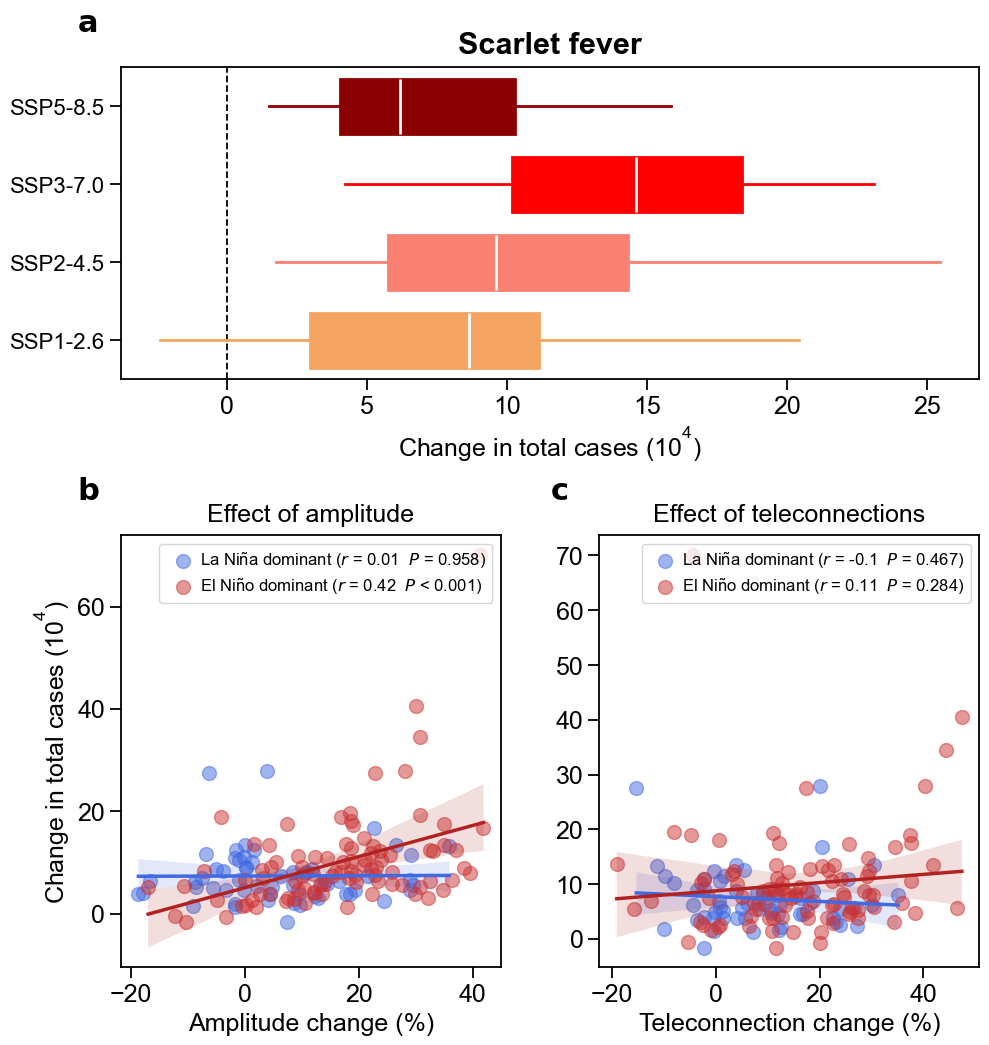

In [20]:
fig = plt.figure(figsize=(11,12))

rcParams["font.family"] = "Arial"
rcParams["font.sans-serif"] = ["Arial"]
rcParams["font.size"] = 18.0
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

tfs = 18
textfs = 16

scen_cols = ["sandybrown","salmon","red","darkred"]
scen_names = ["SSP1-2.6","SSP2-4.5","SSP3-7.0","SSP5-8.5"]

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.18,right=0.96,top=0.9,bottom=0.64,wspace=0.3,hspace=0.54)

ax = plt.subplot(gs1[0,0])
plt.setp(ax.spines.values(), linewidth=1.3)

    
main_drate = 0.02

scenario_pos = [6,7,8,9]
for ee in np.arange(0,len(exps),1):
    e = exps[ee]
    print(e)
    if e=="ssp126":
        damages_box = damages_126_mean.values.flatten()  
   
    if e=="ssp245":
        damages_box = damages_245_mean.values.flatten()
     
    if e=="ssp370":
        damages_box = damages_370_mean.values.flatten()

    if e=="ssp585":
        damages_box = damages_585_mean.values.flatten()



    lower_percentile=np.percentile(damages_box,2.5)
    upper_percentile=np.percentile(damages_box,97.5)


    print("Median",np.nanmedian(damages_box))
    print("Confidence interval",lower_percentile,upper_percentile)
    print("Skewness",stats.skew(damages_box)) 


    b1 = plt.boxplot(damages_box,sym="",widths=0.7,zorder=2,        
                    vert=False,positions=[scenario_pos[ee]],
                        showcaps=False,patch_artist=True,whis=[2.5,97.5]) 
    for m in range(0,2,1):
        if m == 0:
            b1["boxes"][m].set(color=scen_cols[ee],linewidth=2)    
            b1["medians"][m].set(color="white",linewidth=2)  
        b1["whiskers"][m].set(color=scen_cols[ee],linewidth=2)  
    

plt.xlabel("Change in total cases ($10^4$)")
plt.axvline(x=0,linewidth=1.3,color="black",linestyle="--",zorder=1)

#加粗
plt.title(diease_label,fontsize=22,pad=10,loc="center",fontweight="bold")


lbs = ["SSP1-2.6","SSP2-4.5","SSP3-7.0","SSP5-8.5"]
plt.yticks(ticks=scenario_pos,labels=lbs,fontsize=16)    
#plt.ylim([0.3,4.7])



gs3 = gridspec.GridSpec(1,2)
gs3.update(left=0.18,right=0.96,top=0.51,bottom=0.15,wspace=0.26,hspace=0.54)

for k in [0,1]:
    ax = plt.subplot(gs3[0,k])  
    plt.setp(ax.spines.values(), linewidth=1.3)

    if k == 0:
        plt.title("Effect of amplitude",fontsize=tfs,pad=10)
        x1 = amp_change_e_pct_pooled   
        x2 = amp_change_c_pct_pooled  
    else:
        plt.title("Effect of teleconnections",fontsize=tfs,pad=10)
        x1 = tc_change_e_pct_pooled   
        x2 = tc_change_c_pct_pooled   
        
    y = damages_pooled
    
    
    # e_sum colorbar
    vmin = -16  
    vmax = 16
    ncol = 17
    bounds = np.linspace(vmin,vmax,ncol)
    cols = plt.get_cmap('coolwarm')(np.linspace(0,1,len(bounds)+1))
    cm = colors.ListedColormap(cols[1:-1])
    cm.set_over(cols[-1])  
    cm.set_under(cols[0])
    norm = colors.Normalize(vmin=vmin,vmax=vmax)  
    cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)  

   
    z1 = e_sum_pooled*1.0  
    z2= c_sum_pooled*1.0   

  
    r,p = stats.pearsonr(x2[z2<0],y[z2<0])
   
    if str(np.around(p,3))=="0.0":
           plt.scatter(x2[z2<0],y[z2<0],facecolor="royalblue",s=100,alpha=0.5,  
               label="La Ni${\~n}$a dominant ($\it{r}$ = "+str(np.around(r,2))+"  $\it{P}$ < 0.001)")  
  
    else:
        plt.scatter(x2[z2<0],y[z2<0],facecolor="royalblue",s=100,alpha=0.5, 
                label="La Ni${\~n}$a dominant ($\it{r}$ = "+str(np.around(r,2))+"  $\it{P}$ = "+str(np.around(p,3))+')')
    
              
    regplt0 = sns.regplot(x=x2[z2<0],y=y[z2<0],scatter=False,color="royalblue", 
                truncate=True,line_kws={"linestyle":"-","linewidth":2.5})

    beta, intercept, r2_c, p2_c, se = stats.linregress(x2[z2<0],y[z2<0])
    print("La Niña dominant",beta,intercept,r2_c,p2_c,se)
    

    r,p = stats.pearsonr(x1[z1>0],y[z1>0])
    
    if str(np.around(p,3))=="0.0":
        plt.scatter(x1[z1>0],y[z1>0],facecolor=[0.8,0.2,0.2],s=100,      
               alpha=0.5,label="El Ni${\~n}$o dominant ($\it{r}$ = "+str(np.around(r,2))+"  $\it{P}$ < 0.001)")
    elif p<0.05:
        plt.scatter(x1[z1>0],y[z1>0],facecolor=[0.8,0.2,0.2],s=100,      
               alpha=0.5,label="El Ni${\~n}$o dominant ($\it{r}$ = "+str(np.around(r,2))+"  $\it{P}$ < 0.05)")
    elif p<0.005:
        plt.scatter(x1[z1>0],y[z1>0],facecolor=[0.8,0.2,0.2],s=100,      
               alpha=0.5,label="El Ni${\~n}$o dominant ($\it{r}$ = "+str(np.around(r,2))+"  $\it{P}$ < 0.005)")
    else:
        plt.scatter(x1[z1>0],y[z1>0],facecolor=[0.8,0.2,0.2],s=100,      
                alpha=0.5,label="El Ni${\~n}$o dominant ($\it{r}$ = "+str(np.around(r,2))+"  $\it{P}$ = "+str(np.around(p,3))+')')  
  
    regplt1 = sns.regplot(x=x1[z1>0],y=y[z1>0],scatter=False,color="firebrick",  
                truncate=True,line_kws={"linestyle":"-","linewidth":2.5})



    beta, intercept, r2_e, p2_e, se = stats.linregress(x1[z1>0],y[z1>0])
    print("El Niño dominant",beta,intercept,r2_e,p2_e,se)
   
         
    if k == 0:
        plt.ylabel("Change in total cases ($10^4$)")
        plt.xlabel("Amplitude change (%)")
        leg = plt.legend(loc="upper right",frameon=True,fontsize=12,
                handletextpad=0.01,markerscale=1,bbox_to_anchor=(1,1,0,0),
                title = "",labelspacing=0.3)

    if k == 1:
        plt.xlabel("Teleconnection change (%)")
        # plt.xlim([-25,50])
        leg = plt.legend(loc="upper right",frameon=True,fontsize=12,
                handletextpad=0.01,markerscale=1,bbox_to_anchor=(1,1,0,0),
                title = "",labelspacing=0.3) 
        plt.setp(leg.get_title(),fontsize=16)
        leg._legend_box.align = "left"
    
    

plt.figtext(0.14,0.93,r'$\bf{a}$',fontsize=22)
plt.figtext(0.14,0.54,r'$\bf{b}$',fontsize=22)
plt.figtext(0.57,0.54,r'$\bf{c}$',fontsize=22)
pngfile="../../Figures/Fig6_"+disease+"_e_sum换方式.png"
plt.savefig(pngfile,dpi=300)
plt.show()